In [1]:
import datetime
import itertools
import numpy as np
import pandas as pd
from math import sqrt
from pylab import rcParams
from pandas import read_csv
import statsmodels.api as sm
from matplotlib import pyplot
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from pandas.plotting import lag_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf

ruta = 'C://TweetsPositivosMuertes.csv'
df = pd.read_csv(ruta, header=0)
df.head()

,Fecha,Polarity,Positivos,Muertes
0,2020-02-28,-0.361114,1,0
1,2020-02-29,-0.204301,1,0
2,2020-03-01,-0.200173,0,0
3,2020-03-02,-0.179771,2,0
4,2020-03-03,-0.153471,3,0


<AxesSubplot:xlabel='Fecha'>

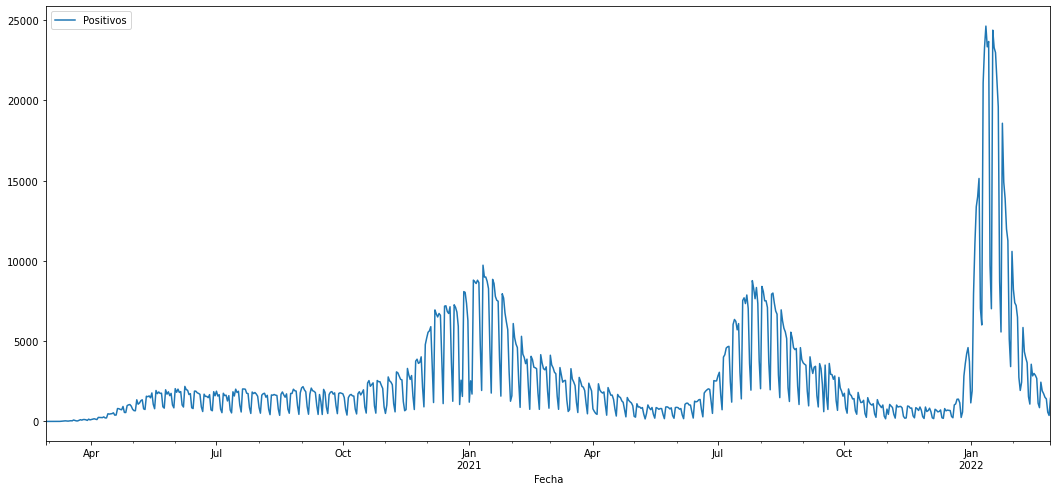

In [4]:
rcParams['figure.figsize'] = 18, 8
series = pd.read_csv(ruta, index_col='Fecha')
series.index = pd.DatetimeIndex(series.index).to_period('D')
series = series[['Positivos']]
series.plot()

In [2]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [7]:
final_list = []
for param in pdq:
  for param_seasonal in seasonal_pdq:
    try:
      mod = sm.tsa.statespace.SARIMAX(series, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
      results = mod.fit()
      final_list.append('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
    except:
        continue
final_list

C:\Users\jose.jimenez\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


['ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:14259.168852104935',
 'ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:13703.761596027529',
 'ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:13708.503625344756',
 'ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:13448.604401937419',
 'ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:13606.048032945748',
 'ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:13590.429391068903',
 'ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:13491.581923042186',
 'ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:13322.417576268705',
 'ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:13721.614213656276',
 'ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:13113.434994097632',
 'ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:13235.643564934962',
 'ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:12874.745324577321',
 'ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:13085.51615214921',
 'ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:13050.574829855357',
 'ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:13002.837146421003',
 'ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:12861.370113953986',
 'ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:13

<h3>Aquí el modelo se ejecuta con los parámetros más óptimos encontrados en el paso anterior</h3>

In [5]:
mod = sm.tsa.statespace.SARIMAX(series, order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4391      0.032     13.850      0.000       0.377       0.501
ma.L1         -0.7688      0.022    -34.844      0.000      -0.812      -0.726
ar.S.L12      -0.2368      0.020    -11.883      0.000      -0.276      -0.198
ma.S.L12      -1.0020      0.020    -51.183      0.000      -1.040      -0.964
sigma2       3.04e+06   6.26e-09   4.85e+14      0.000    3.04e+06    3.04e+06


C:\Users\jose.jimenez\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


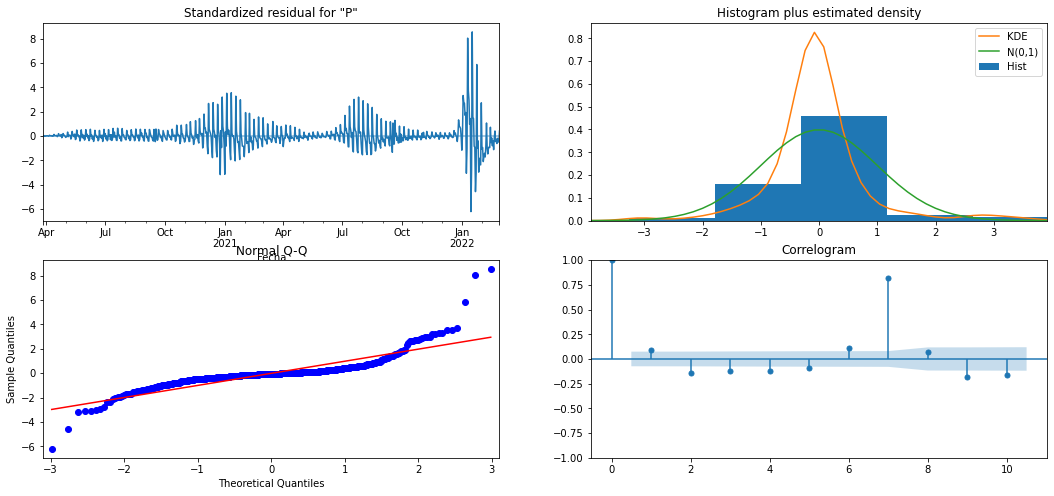

In [7]:
results.plot_diagnostics(figsize=(18,8))
plt.show()

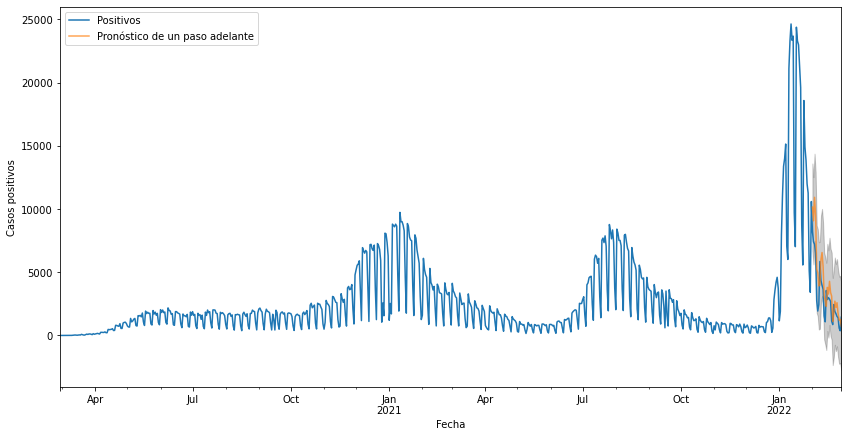

In [13]:
dateforecast = '2022-02-01'
pred = results.get_prediction(start=pd.to_datetime(dateforecast), dynamic=False)
pred_ci = pred.conf_int()
ax = series.plot(label='Observado')
pred.predicted_mean.plot(ax=ax, label='Pronóstico de un paso adelante', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Fecha')
ax.set_ylabel('Casos positivos')
plt.legend()
plt.show()

In [12]:
#Aquí obtenemos el RMSE de la serie de tiempo pronosticada.
y_forecasted = pred.predicted_mean
y_truth = series[dateforecast:]
y_truth = y_truth['Positivos']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('El error cuadrático medio de nuestros pronósticos es {}'.format(round(np.sqrt(mse), 2)))

El error cuadrático medio de nuestros pronósticos es 1709.06


<h2>Realizamos todo el proceso anterior ahora para la variable muertes, para evaluar su efectividad</h2>

In [15]:
rcParams['figure.figsize'] = 18, 8
series = pd.read_csv(ruta, index_col='Fecha')
series.index = pd.DatetimeIndex(series.index).to_period('D')
series = series[['Muertes']]

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

final_list = []
for param in pdq:
  for param_seasonal in seasonal_pdq:
    try:
      mod = sm.tsa.statespace.SARIMAX(series, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
      results = mod.fit()
      final_list.append('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
    except:
        continue
final_list

['ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:9495.77020003591',
 'ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:8546.955822448306',
 'ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:7478.022538234194',
 'ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:7196.676748146794',
 'ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:7476.7623812911315',
 'ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:7291.123511336557',
 'ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:7155.941952930244',
 'ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:7148.469196489889',
 'ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:8578.62052461659',
 'ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:7891.527824338753',
 'ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:7042.672659490401',
 'ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:6910.572720866483',
 'ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:7044.3167942659275',
 'ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:6995.942527822226',
 'ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:6916.067446221857',
 'ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:6894.746404152447',
 'ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:6164.052392139871

In [16]:
mod = sm.tsa.statespace.SARIMAX(series, order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4018      0.029    -13.877      0.000      -0.459      -0.345
ma.S.L12      -1.0000    158.423     -0.006      0.995    -311.504     309.504
sigma2       248.2385   3.93e+04      0.006      0.995   -7.68e+04    7.73e+04


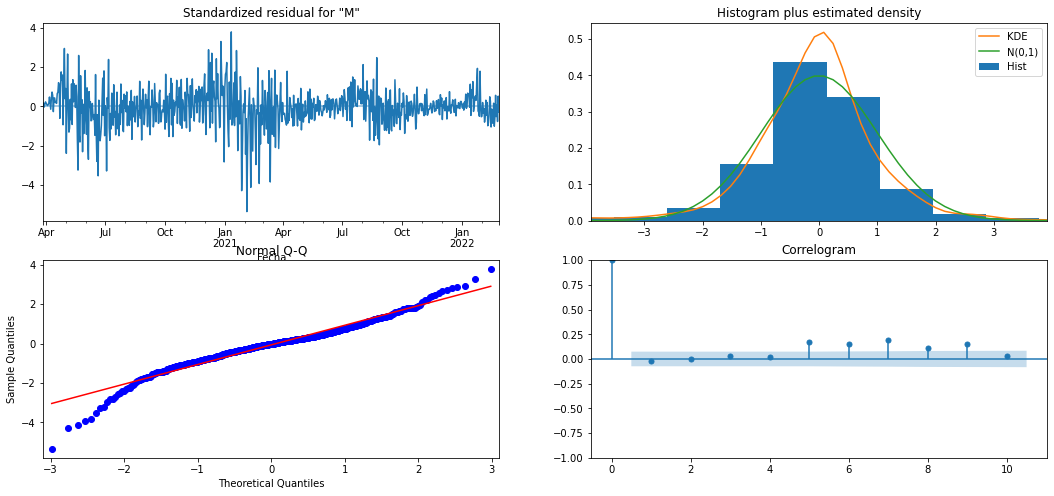

In [17]:
results.plot_diagnostics(figsize=(18,8))
plt.show()

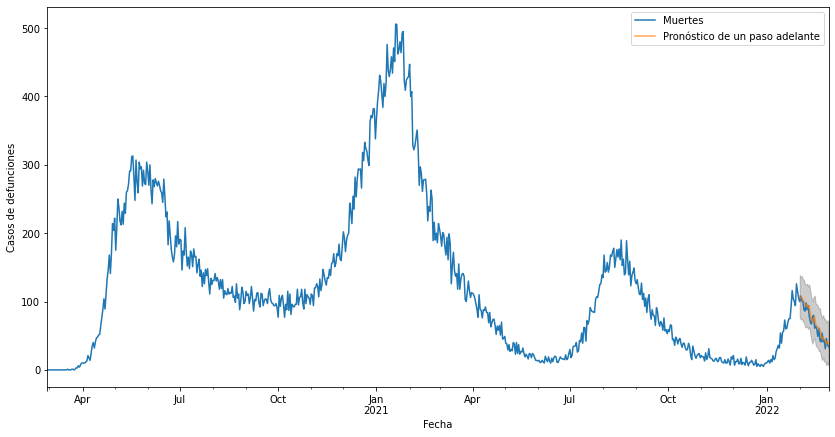

In [19]:
dateforecast = '2022-02-01'
pred = results.get_prediction(start=pd.to_datetime(dateforecast), dynamic=False)
pred_ci = pred.conf_int()
ax = series.plot(label='Observado')
pred.predicted_mean.plot(ax=ax, label='Pronóstico de un paso adelante', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Fecha')
ax.set_ylabel('Casos de defunciones')
plt.legend()
plt.show()

In [20]:
#Aquí obtenemos el RMSE de la serie de tiempo pronosticada.
y_forecasted = pred.predicted_mean
y_truth = series[dateforecast:]
y_truth = y_truth['Muertes']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('El error cuadrático medio de nuestros pronósticos es {}'.format(round(np.sqrt(mse), 2)))

El error cuadrático medio de nuestros pronósticos es 8.85
